<a href="https://colab.research.google.com/github/Lursen/ANN-edge-detection/blob/main/Edge_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from random import uniform as randnum
from math import e


Функция загрузки изображений
(возвращает оригинальные и преобразованные матрицей Собеля изображения)

In [ ]:
def get_Images(img_paths):
  imgs = []
  for path in img_paths:
    img = Image.open(path)
    img = img.resize((99,99))
    img_gray = np.mean(img, axis=-1)
    imgs.append(img_gray)

  sobel_matrix_1 = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
  sobel_matrix_2 = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  edge_imgs = []
  for img in imgs:
    sob_image = np.zeros(img.shape)
    for i in range(1, len(sob_image)-1):
      for j in range(1, len(sob_image[0])-1):
        Gx = np.abs(np.sum(img[i-1:i+2, j-1:j+2] * sobel_matrix_1))
        Gy = np.abs(np.sum(img[i-1:i+2, j-1:j+2] * sobel_matrix_2))
        sob_image[i, j] = np.sqrt((Gx*Gx) + (Gy*Gy))
    sob_image *= 255.0/sob_image.max()
    edge_imgs.append(sob_image)

  return imgs, edge_imgs

Создание обуч. и тест. выборок

In [ ]:
def get_TrainingTestSets(imgs, edges, N=3):
  img_slices = []
  edge_slices = []

  for img in imgs:
    for i in range(0,np.asarray(img).shape[0] ,N):
      for j in range(0,np.asarray(img).shape[1] ,N):
        img_slice = np.asarray(img)[i:i+N,j:j+N]
        img_slices.append(img_slice)

  for edge in edges:
    for i in range(0,np.asarray(edge).shape[0] ,N):
      for j in range(0,np.asarray(edge).shape[1] ,N):
        edge_slice = np.asarray(edge)[i:i+N,j:j+N]
        edge_slices.append(edge_slice)

  return img_slices, edge_slices  

In [ ]:
from sklearn.model_selection import train_test_split

N = 3
paths = ['img1.jpg','img2.jpg','img3.jpg','img4.jpg','img5.jpg','img6.jpg','img7.jpg','img8.jpg','img9.jpg','img10.jpg']
imgs, edges = get_Images(paths)
img_slices, edge_slices = np.asarray(get_TrainingTestSets(imgs, edges))
img_slices = img_slices / 255
edge_slices = edge_slices / 255

img_norm = []
edges_norm = []

for img in img_slices:
  img_norm.append(np.reshape(img,N*N))

for img in edge_slices:
  edges_norm.append(np.reshape(img,N*N))

X_train, X_test, y_train, y_test = train_test_split(np.asarray(img_norm), np.asarray(edges_norm), test_size=0.1, random_state=42)


Класс сети прямого распространения

In [ ]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
x = torch.ones(1, requires_grad=True)

class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size

            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
            self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
            self.fcOut = torch.nn.Linear(self.hidden_size, self.input_size)

            self.sigmoid = torch.nn.Sigmoid()
            self.relu = torch.nn.ReLU()
            self.tanh = torch.nn.Tanh()

        def forward(self, x):
            hidden1 = self.fc1(x)
            sigmoid1 = self.tanh(hidden1)

            hidden2 = self.fc2(sigmoid1)
            sigmoid2 = self.relu(hidden2)

            output = self.fcOut(sigmoid2)
            output = self.relu(output)
            return output

Обучение сети

In [ ]:
model = Feedforward(9,120)
criterion = torch.nn.L1Loss() #
optimizer = torch.optim.SGD(model.parameters(), lr = 0.2)
error = []
# training
model.train()
model.double()
epoch = 20000
for epoch in range(epoch):
    rnd = np.random.randint(0,np.shape(X_train))
    xs = torch.from_numpy(X_train[rnd])
    ys = torch.tensor(y_train[rnd])

    optimizer.zero_grad()
    # Forward pass
    y_pred = model(xs)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), ys)
    # Backward pass
    loss.backward()
    optimizer.step()
    error.append(loss.item())
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
print('Training error:', np.mean(np.asarray(error)))    

Тестирование

In [ ]:
test = ['test.jpg']
test_img, test_edges = get_Images(test)

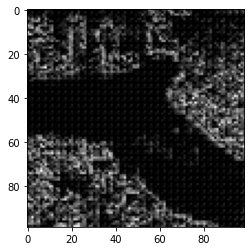

In [ ]:
img = imgs[8]
N = 3
result = np.zeros_like(img)
for i in range(0,np.asarray(img).shape[0] ,N):
  for j in range(0,np.asarray(img).shape[1] ,N):
    slc = np.asarray(img)[i:i+N,j:j+N]
    slc = np.reshape(slc,N*N)
    new = model(torch.from_numpy(slc))
    new = new.cpu().detach().numpy()
    new = np.reshape(new, (N,N))
    result[i:i+N,j:j+N] = new

plt.imshow(result, cmap='gray')

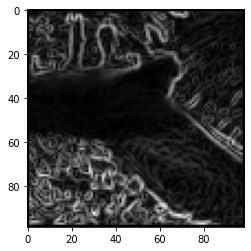

In [ ]:
plt.imshow(edges[8], cmap='gray')